In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.simplefilter('ignore')

In [1]:
import json
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import folium

from shapely.geometry import Point, Polygon
import geopandas

from preprocess import Preprocess, Preprocess_DVF
from loader import Loader
from tools import pfreq_cat

ModuleNotFoundError: No module named 'preprocess'

# 0. Load prepared data

#### 0. 1. Cleaned datatable for Paris, part and pro (housing and commercial housing/ warehouses)

In [4]:
from loader import Loader
df = Loader(filename='DVF_Paris').load_data()
df.head()

ImportError: cannot import name 'Loader'

# APUR

In [3]:
df_all = pd.read_csv('data/output/DVF_Paris_v4.csv')
print(df_all.shape)
df_master_2 = df_all.dropna(subset=["Lat", "Long"])
print(df_master_2.shape)

df_master_2[["Lat", "Long", "Code_postal"]].head()

(182238, 144)
(181959, 144)


,Lat,Long,Code_postal
0,48.836240,2.254023,75016
1,48.844121,2.251979,75016
2,48.837740,2.252696,75016
3,48.835491,2.254658,75016
4,48.835760,2.254422,75016


In [4]:
df_coord = df_master_2[["Lat", "Long"]].drop_duplicates()
print(df_coord.shape)

df_coord["geometry"] = df_coord.apply(lambda x: Point(x["Long"], x["Lat"]), axis=1)
df_coord = geopandas.GeoDataFrame(df_coord, geometry="geometry")

(39324, 2)


In [5]:
apur_geojson = geopandas.read_file("data/source/APUR/EMPRISE_BATIE_PARIS.geojson")
apur_geojson.head()

,OBJECTID,n_sq_eb,b_igh,b_er,b_ee,an_const,an_rehab,an_rehabf,c_perconst,b_dalle,...,m2_e_70_80,m2_e_80_90,m2_e_90_10,m2_e_s1000,m2_e_tot,c_source,c_morpho,Shape_Length,Shape_Area,geometry
0,1,750092416,Non,Non,Non,NaN,NaN,NaN,1915 - 1939,Non,...,27.0,39.0,26.0,54.0,207.0,None,Immeuble collectif de plus de 3 étages,90.417718,207.669519,"POLYGON ((2.282915167997954 48.84453489386718,..."
1,2,750093235,Non,Non,Oui,NaN,NaN,NaN,Non-daté,Non,...,14.0,6.0,3.0,2.0,196.0,None,Immeuble collectif de moins de 3 étages (<500m²),76.182832,197.237473,"POLYGON ((2.249634989283148 48.84789104146548,..."
2,3,750111911,Non,Non,Non,1910.0,NaN,NaN,1851 - 1914,Non,...,28.0,32.0,22.0,11.0,206.0,None,Immeuble collectif de plus de 3 étages,67.374241,204.870376,"POLYGON ((2.292910953667015 48.84731273405361,..."
3,4,750110170,Non,Non,Non,1897.0,NaN,NaN,1851 - 1914,Oui,...,6.0,0.0,0.0,0.0,135.0,None,Logement individuel,58.528564,134.396968,"POLYGON ((2.329432874653439 48.82813914092512,..."
4,5,750120790,Non,Non,Non,NaN,NaN,NaN,1851 - 1914,Non,...,42.0,81.0,39.0,109.0,360.0,None,Immeuble collectif de plus de 3 étages,94.007567,360.347001,"POLYGON ((2.378044064254614 48.89119907130411,..."


In [6]:
corres_table_coord_apur = geopandas.tools.sjoin(df_coord, apur_geojson, how="left")
print(corres_table_coord_apur.shape)
corres_table_coord_apur.head()

/Users/mathilde_lavacquery/anaconda3/lib/python3.7/site-packages/geopandas/tools/sjoin.py:56: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326'})
  '(%s != %s)' % (left_df.crs, right_df.crs))


(39324, 39)


,Lat,Long,geometry,index_right,OBJECTID,n_sq_eb,b_igh,b_er,b_ee,an_const,...,m2_e_in700,m2_e_70_80,m2_e_80_90,m2_e_90_10,m2_e_s1000,m2_e_tot,c_source,c_morpho,Shape_Length,Shape_Area
0,48.836240,2.254023,POINT (2.254023 48.83624),NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,48.844121,2.251979,POINT (2.251979 48.844121),NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,48.837740,2.252696,POINT (2.252696 48.83774),NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,48.835491,2.254658,POINT (2.254658 48.835491),NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,48.835760,2.254422,POINT (2.254422 48.83576),NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
corres_table_coord_apur[~corres_table_coord_apur['n_sq_eb'].isna()].shape

(34386, 39)

In [11]:
corres_table_coord_apur.to_csv('data/output/corres_table_coord_apur.csv', index=False)

In [12]:
df_master_3 = df_all.merge(corres_table_coord_apur, on=["Lat", "Long"], how="left")
print(df_master_3.shape)
print(df_master_3.dropna(subset=["n_sq_eb"]).shape)

(182238, 181)
(153026, 181)


In [13]:
df_master_3.to_csv('data/output/DVF_Paris_v5.csv', index=False)

In [17]:
# with open("data/source/APUR/EMPRISE_BATIE_PARIS.geojson", 'r') as data_file:    
#     apur_json = json.load(data_file)

In [18]:
# polygon_1 = apur_json['features'][0]['geometry']['coordinates'][0]
# polygon_1

[[2.282915167997954, 48.84453489386718],
 [2.2827004830455144, 48.84461700250757],
 [2.2826227810732798, 48.84452757383328],
 [2.2827196096004876, 48.844490917904395],
 [2.2827289485688467, 48.844502535270784],
 [2.2827511288934694, 48.8445278181743],
 [2.2827718452671273, 48.84452036520309],
 [2.2827926629955133, 48.84454465781963],
 [2.2827733072897387, 48.844552648679475],
 [2.2827807963011137, 48.84456145971516],
 [2.2828602560526785, 48.844532182282954],
 [2.2828084173609473, 48.84447200240854],
 [2.2827984913935118, 48.84446105605491],
 [2.2828944334640355, 48.844424733731096],
 [2.2829733480152687, 48.84451261179807],
 [2.282915167997954, 48.84453489386718]]

In [25]:
# m = folium.Map(location=[48.85, 2.33], tiles='cartodbpositron', zoom_start=11)

# colors = plt.cm.get_cmap('PuRd')

# for coord_ in polygon_1:
#     print(coord_)
#     folium.Circle(
#         location=coord_ ,
#         popup=coord_,
#         radius=500,
#         color='crimson',
#         fill=True,
#         fill_color='crimson'
#     ).add_to(m)

# m

[2.282915167997954, 48.84453489386718]
[2.2827004830455144, 48.84461700250757]
[2.2826227810732798, 48.84452757383328]
[2.2827196096004876, 48.844490917904395]
[2.2827289485688467, 48.844502535270784]
[2.2827511288934694, 48.8445278181743]
[2.2827718452671273, 48.84452036520309]
[2.2827926629955133, 48.84454465781963]
[2.2827733072897387, 48.844552648679475]
[2.2827807963011137, 48.84456145971516]
[2.2828602560526785, 48.844532182282954]
[2.2828084173609473, 48.84447200240854]
[2.2827984913935118, 48.84446105605491]
[2.2828944334640355, 48.844424733731096]
[2.2829733480152687, 48.84451261179807]
[2.282915167997954, 48.84453489386718]


#### 0. 2. Cleaned datatable for Paris, part and pro (housing and commercial housing/ warehouses)

In [90]:
df = Loader(filename='DVF_Paris', data_to_add=['meteo', 'geocode']).load_data()
print(df.shape)
df.head()

(284647, 47)


,No disposition,Date mutation,Nature mutation,Valeur fonciere,No voie,B/T/Q,Type de voie,Code voie,Voie,Code postal,...,Prix m2,Prix m2 Carrez,MONTH,YEAR,AVG_TEMP,PRECIP_TOTAL_DAY_MM,CLOUDCOVER_AVG_PERCENT,Adresse,Lat,Long
0,1,2014-01-10,vente,348000.0,17,NaN,av,3520,ferdinand buisson,75016,...,7250.000000,NaN,1,2014,7.467742,2.583871,57.149194,"17, av ferdinand buisson, 75016, boulogne-bill...",48.836783,2.253639
1,1,2014-01-10,vente,1020000.0,22,NaN,rue,6660,nungesser et coli,75016,...,NaN,6982.475356,1,2014,7.467742,2.583871,57.149194,"22, rue nungesser et coli, 75016, boulogne-bil...",48.844895,2.252490
2,1,2014-01-10,vente,1020000.0,22,NaN,rue,6660,nungesser et coli,75016,...,7183.098592,6982.475356,1,2014,7.467742,2.583871,57.149194,"22, rue nungesser et coli, 75016, boulogne-bil...",48.844895,2.252490
3,1,2014-02-03,vente,615000.0,35,NaN,av,3520,ferdinand buisson,75016,...,7987.012987,7909.967846,2,2014,7.785714,3.578571,47.500000,"35, av ferdinand buisson, 75016, boulogne-bill...",48.836783,2.253639
4,1,2014-01-30,vente,450000.0,7,NaN,av,3520,ferdinand buisson,75016,...,7758.620690,NaN,1,2014,7.467742,2.583871,57.149194,"7, av ferdinand buisson, 75016, boulogne-billa...",48.836783,2.253639


# I. Preparation from sources (if needed)

Sources:
- OpenData Valeurs Fonctières https://cadastre.data.gouv.fr/dvf
- Etalab - répartition et visualisation - Cadastre : https://app.dvf.etalab.gouv.fr/
- GitHub Data.gouv : https://github.com/etalab/DVF-app
- Apur : https://www.apur.org/fr



Other data used:
- Température, pluviométrie: https://www.historique-meteo.net/france/ile-de-france/paris/2014/


## I. 1. Construct Table

- Paris only
- Remove non interesting columns
- Some column remaning (cf class Preprocess_DFV in preprocess.py)
- Data cleaning: mainly removing Na and handling dtypes
- Creating column 'Prix m2 Carrez' by dividing the 'Valeur Fonciere' by the sum of 'Carrez' columns

In [84]:
# Table parameters / year and code postal ----
years = [str(y) for y in range(2014, 2019)]
code_postal = range(75000, 75021)

dfpt = Preprocess_DVF(years=years, code_postal=code_postal).clean_dvf_from_source(save_filename='DVF_Paris')
dfpt.head()

Loading DVF files from source
2014 (55025, 43)
2015 (59977, 43)
2016 (57795, 43)
2017 (63166, 43)
2018 (48684, 43)
Cleaning data
(284647, 39)
File DVF_Paris.csv well saved in data/output


,No disposition,Date mutation,Nature mutation,Valeur fonciere,No voie,B/T/Q,Type de voie,Code voie,Voie,Code postal,...,Type local,Identifiant local,Surface reelle bati,Nombre pieces principales,Nature culture,Nature culture speciale,Surface terrain,Carrez tot,Prix m2,Prix m2 Carrez
0,1,2014-01-10,vente,348000.0,17,NaN,av,3520,ferdinand buisson,75016,...,appartement,NaN,48.0,2.0,NaN,NaN,0.0,0.00,7250.000000,NaN
1,1,2014-01-10,vente,1020000.0,22,NaN,rue,6660,nungesser et coli,75016,...,dependance,NaN,0.0,0.0,NaN,NaN,0.0,146.08,NaN,6982.475356
2,1,2014-01-10,vente,1020000.0,22,NaN,rue,6660,nungesser et coli,75016,...,appartement,NaN,142.0,4.0,NaN,NaN,0.0,146.08,7183.098592,6982.475356
3,1,2014-02-03,vente,615000.0,35,NaN,av,3520,ferdinand buisson,75016,...,appartement,NaN,77.0,4.0,NaN,NaN,0.0,77.75,7987.012987,7909.967846
4,1,2014-01-30,vente,450000.0,7,NaN,av,3520,ferdinand buisson,75016,...,appartement,NaN,58.0,2.0,NaN,NaN,0.0,0.00,7758.620690,NaN


## I. 2. Basic Description

In [286]:
dfpt.dtypes

No disposition                        int64
Date mutation                datetime64[ns]
Nature mutation                      object
Valeur fonciere                     float64
No voie                               int64
B/T/Q                                object
Type de voie                         object
Code voie                            object
Voie                                 object
Code postal                           int64
Commune                              object
Code departement                     object
Code commune                          int64
Prefixe de section                  float64
Section                              object
No plan                               int64
No Volume                            object
1er lot                              object
Carrez 1                            float64
2eme lot                             object
Carrez 2                            float64
3eme lot                             object
Carrez 3                        

In [287]:
dfpt.isna().sum()

No disposition                    0
Date mutation                     0
Nature mutation                   0
Valeur fonciere                   0
No voie                           0
B/T/Q                        272353
Type de voie                      0
Code voie                         0
Voie                              0
Code postal                       0
Commune                           0
Code departement                  0
Code commune                      0
Prefixe de section           284647
Section                           0
No plan                           0
No Volume                    283289
1er lot                       27807
Carrez 1                          0
2eme lot                     184255
Carrez 2                          0
3eme lot                     267722
Carrez 3                          0
4eme lot                     278348
Carrez 4                          0
5eme lot                     281879
Carrez 5                          0
Nombre de lots              

In [382]:
for var in ['Nature mutation', 'Type local', 'Nature culture', 'Nature culture speciale', 'Commune']:
    print(pfreq_cat(dfpt, var))
    print('\t')

                      Nature mutation    Freq       Perc
0                        adjudication     859   0.301777
1                             echange    2158   0.758132
2                       expropriation     117   0.041104
3                               vente  274257  96.349865
4  vente en l'etat futur d'achevement    6910   2.427568
5               vente terrain à batir     346   0.121554
	
                                 Type local    Freq       Perc
0                               appartement  181351  63.710842
1                                dependance   71230  25.023977
2  local industriel. commercial ou assimile   25078   8.810211
3                                    maison     887   0.311614
4                                       nan    6101   2.143357
	
  Nature culture    Freq       Perc
0             AB     314   0.110312
1             AG     234   0.082207
2             CH      44   0.015458
3             NA  258196  90.707438
4              S   25859   9.084585
	
 

In [377]:
print(dfpt['Nombre de lots'].describe())

count    284647.000000
mean          1.370912
std           1.232972
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         285.000000
Name: Nombre de lots, dtype: float64


In [378]:
pfreq_cat(dfpt[dfpt['Nombre de lots'] > 5], 'Type local')

,Type local,Freq,Perc
0,appartement,783,52.339572
1,dependance,79,5.280749
2,local industriel. commercial ou assimile,620,41.443850
3,maison,14,0.935829


In [379]:
pfreq_cat(dfpt[dfpt['Nombre de lots'] <= 5], 'Type local')

,Type local,Freq,Perc
0,appartement,180568,63.770921
1,dependance,71151,25.128288
2,local industriel. commercial ou assimile,24458,8.637794
3,maison,873,0.308316
4,nan,6101,2.154681


In [380]:
pfreq_cat(dfpt, 'Type local')

,Type local,Freq,Perc
0,appartement,181351,63.710842
1,dependance,71230,25.023977
2,local industriel. commercial ou assimile,25078,8.810211
3,maison,887,0.311614
4,nan,6101,2.143357


Beaucoup plus grosse proportion de local commercial dans les lots >5 que dans les lots < 5.


### What surface variable should we use to compute the price/m2 ?

See bellow: Twice less data missing in 'Surface reelle bati' than in Carrez-tot -- so we'll use this one eventhough it's obviously a bad proxy


In [293]:
surface_cols = ['Surface reelle bati', 'Surface terrain', 'Carrez tot']

for col in surface_cols:
    print(col, dfpt[dfpt[col] == 0].shape[0])
    
dfpt[surface_cols].head(20)

Surface reelle bati 77937
Surface terrain 258196
Carrez tot 130234


,Surface reelle bati,Surface terrain,Carrez tot
0,48.0,0.0,0.00
1,0.0,0.0,146.08
2,142.0,0.0,146.08
3,77.0,0.0,77.75
4,58.0,0.0,0.00
5,30.0,0.0,29.88
6,18.0,0.0,17.53
7,77.0,0.0,78.60
8,0.0,0.0,0.00
9,106.0,0.0,96.15


In [294]:
dfpt['Reelle-Carrez'] = dfpt['Surface reelle bati'] - dfpt['Carrez tot']
dfpt['Reelle-Carrez'].describe()

count    284647.000000
mean         17.110881
std         281.667158
min       -9572.000000
25%          -0.500000
50%           0.000000
75%           9.000000
max       37655.000000
Name: Reelle-Carrez, dtype: float64

In [295]:
print(dfpt[(dfpt['Reelle-Carrez'] < -10) |  (dfpt['Reelle-Carrez'] > 10)].shape[0]/dfpt.shape[0]*100)

# Quand meme 30% des biens qui ont plus de 10m2 de diff entre 'Bati réel' et 'Carrez'

30.076199643769304


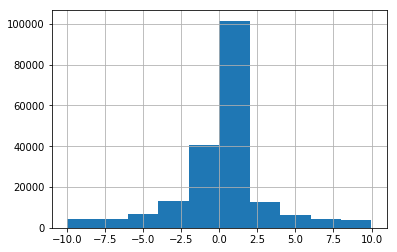

In [296]:
dfpt[(dfpt['Reelle-Carrez'] > -10) &  (dfpt['Reelle-Carrez'] < 10)]['Reelle-Carrez'].hist()

## I. 3. Add Temperature

- Data source: https://www.historique-meteo.net/france/ile-de-france/paris/2014/

In [31]:
dfpt = Preprocess(dfpt).create_date_columns(date_source = 'Date mutation',
                                            new_dates=['MONTH', 'YEAR', 'Date ordinal'])
dfpt.head()

,No disposition,Date mutation,Nature mutation,Valeur fonciere,No voie,B/T/Q,Type de voie,Code voie,Voie,Code postal,...,Nombre pieces principales,Nature culture,Nature culture speciale,Surface terrain,Carrez tot,Prix m2,Prix m2 Carrez,MONTH,YEAR,Date ordinal
0,1,2014-01-10,vente,348000.0,17.0,NaN,AV,3520,ferdinand buisson,75016.0,...,2.0,NaN,NaN,0.0,0.00,7250.000000,NaN,1,2014,735243
1,1,2014-01-10,vente,1020000.0,22.0,NaN,RUE,6660,nungesser et coli,75016.0,...,0.0,NaN,NaN,0.0,146.08,NaN,6982.475356,1,2014,735243
2,1,2014-01-10,vente,1020000.0,22.0,NaN,RUE,6660,nungesser et coli,75016.0,...,4.0,NaN,NaN,0.0,146.08,7183.098592,6982.475356,1,2014,735243
3,1,2014-02-03,vente,615000.0,35.0,NaN,AV,3520,ferdinand buisson,75016.0,...,4.0,NaN,NaN,0.0,77.75,7987.012987,7909.967846,2,2014,735267
4,1,2014-01-30,vente,450000.0,7.0,NaN,AV,3520,ferdinand buisson,75016.0,...,2.0,NaN,NaN,0.0,0.00,7758.620690,NaN,1,2014,735263


In [45]:
d_temp = Preprocess_DVF().load_temp_from_source(save_filename='paris_meteo_month')
d_temp.head()

(60, 5)


,YEAR,MONTH,AVG_TEMP,PRECIP_TOTAL_DAY_MM,CLOUDCOVER_AVG_PERCENT
0,2014,1,7.467742,2.583871,57.149194
1,2014,2,7.785714,3.578571,47.500000
2,2014,3,11.903226,0.674194,27.883065
3,2014,4,13.650000,1.270000,39.962500
4,2014,5,15.387097,2.309677,43.322581


In [300]:
dfpt_temp  = pd.merge(dfpt, d_temp, on = ['YEAR', 'MONTH'], how = 'left')
dfpt_temp.head()

,No disposition,Date mutation,Nature mutation,Valeur fonciere,No voie,B/T/Q,Type de voie,Code voie,Voie,Code postal,...,Prix m2,Prix m2 Carrez,Reelle-Carrez,MONTH,YEAR,Date ordinal,AVG_TEMP,PRECIP_TOTAL_DAY_MM,CLOUDCOVER_AVG_PERCENT,Y-M
0,1,2014-01-10,vente,348000.0,17,NaN,av,3520,ferdinand buisson,75016,...,7250.000000,NaN,48.00,1,2014,735243,7.467742,2.583871,57.149194,2014-01-01
1,1,2014-01-10,vente,1020000.0,22,NaN,rue,6660,nungesser et coli,75016,...,NaN,6982.475356,-146.08,1,2014,735243,7.467742,2.583871,57.149194,2014-01-01
2,1,2014-01-10,vente,1020000.0,22,NaN,rue,6660,nungesser et coli,75016,...,7183.098592,6982.475356,-4.08,1,2014,735243,7.467742,2.583871,57.149194,2014-01-01
3,1,2014-02-03,vente,615000.0,35,NaN,av,3520,ferdinand buisson,75016,...,7987.012987,7909.967846,-0.75,2,2014,735267,7.785714,3.578571,47.500000,2014-02-01
4,1,2014-01-30,vente,450000.0,7,NaN,av,3520,ferdinand buisson,75016,...,7758.620690,NaN,58.00,1,2014,735263,7.467742,2.583871,57.149194,2014-01-01


In [457]:
dfpt_temp.to_csv("data/output/DVF_Paris_temp.csv", index=False, header=True)

## I. 4. Add Geocoding - corres table for other info to add

In [4]:
dfpt = Loader(filename='DVF_Paris').load_data()
geo = dfpt[['No voie', 'Type de voie', 'Voie', 'Code postal', 'Commune']]
print(geo.shape)
geo = geo.drop_duplicates()
print(geo.shape)

geo['Adresse'] = geo.apply(lambda x: '{}, {} {}, {}, {}'\
                           .format(x['No voie'], x['Type de voie'], x['Voie'], 
                                   x['Code postal'], x['Commune']), axis = 1)
geo = geo.reset_index(drop = True)
geo.head()

(284647, 5)
(42890, 5)


In [ ]:
# Requesting Geocodes for each adress, via library Geocoder 
# (provider = Yandex, limited to 25000 requests per day)

corres_geo = pd.DataFrame(columns=['Adresse', 'Lat', 'Long'])
start = 33075

corres_geo = geocode_from_list(geo['Adresse'], start=start, corres_geo=corres_geo)

Status code Unknown from https://geocode-maps.yandex.ru/1.x/: ERROR - HTTPSConnectionPool(host='geocode-maps.yandex.ru', port=443): Read timed out. (read timeout=5.0)
Status code Unknown from https://geocode-maps.yandex.ru/1.x/: ERROR - HTTPSConnectionPool(host='geocode-maps.yandex.ru', port=443): Max retries exceeded with url: /1.x/?geocode=39%2C+rue+des+plantes%2C+75014%2C+paris+14&lang=en-US&kind=&format=json&results=1 (Caused by SSLError(SSLError("bad handshake: Error([('SSL routines', 'tls_process_server_certificate', 'certificate verify failed')],)",),))
Status code Unknown from https://geocode-maps.yandex.ru/1.x/: ERROR - HTTPSConnectionPool(host='geocode-maps.yandex.ru', port=443): Max retries exceeded with url: /1.x/?geocode=50%2C+rue+de+la+sabliere%2C+75014%2C+paris+14&lang=en-US&kind=&format=json&results=1 (Caused by SSLError(SSLError("bad handshake: Error([('SSL routines', 'tls_process_server_certificate', 'certificate verify failed')],)",),))
Status code Unknown from https

In [ ]:
# Merging dataframes of different requests (due to limitation in requests, done in several days)

geo_paris = create_geo_paris(['Paris-v2', 'v42800'], 'paris_geocode_v3')
geo_paris.head()